# Congressional Election EDA and Predictive Modelling

## Election Results

The first set of data is publicly available on the [Federal Election Commission's (FEC) website](https://www.fec.gov/introduction-campaign-finance/election-and-voting-information/). Data going back to 2004 is available in a readable Excel format. Data prior to 2004 was not able to be read into tabular format easily. I have converted each to it's own csv file and read each of them in below.

One preliminary note about all vote totals and results; special elections are not considered in the statistics and calculations. 

A few examples of oddities that may yild conflicting results include, but are not limited to:
1. Vote counts by election year will not include special election totals when summed.
2. Party gains and holds may be incorrect when a special election is held for an unexpired term (i.e. a Democrat fills a seat previously held by a Republican, only to be defeated by a Republican in the general election. This would register as a "Republican Hold" instead of "Republican Gain" because the previous full-term incumbent was Republican.)
3. A candidate switches parties after registering. The elected party will be assigned as their party and the incumbent party (ex. Rodney Alexander in LA 5th District registered as a Democrat and then changed registration to Republican in 2004)
4. The underlying data is incorrect (ex. NY 21st District is incorrect, containing records with multiple incumbents and registering that the Republican ran unopposed when a Democrat recived votes in the general election). I have not made any fundamental alterations to the base data from the FEC website.


In [47]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import janitor
import numpy as np

electionFiles = [f for f in listdir(r"FEC Election Data\House and Senate Primary Sheets") 
if isfile(join(r"FEC Election Data\House and Senate Primary Sheets", f))]

In [48]:
electionFiles

['2004congresults_2004 US HOUSE & SENATE RESULTS.csv',
 '2008congresults_2008 House and Senate Results.csv',
 '2012congresults_2012 US House & Senate Results.csv',
 'federalelections2016_2016 US House Results by State.csv',
 'federalelections2016_2016 US Senate Results by State.csv',
 'federalelections2018_2018 US House Results by State.csv',
 'federalelections2018_2018 US Senate Results by State.csv',
 'federalelections2020_12. US Senate Results by State.csv',
 'federalelections2020_13. US House Results by State.csv',
 'results06_2006 US House & Senate Results.csv',
 'results10_2010 US House & Senate Results.csv',
 'results14_2014 US House Results by State.csv',
 'results14_2014 US Senate Results by State.csv']

The data from the FEC has inconsistent headers. I have created a reference CSV file to assign a normalized heading to each year's file.

In [49]:
pd.read_csv(r"FEC Election Data\FEC COLUMN HEADINGS.csv",encoding_errors='replace').sample(10)

,ColumnID,ColumnName,ColumnNameNorm,ElectionYear
127,21,COMBINED %,COMBINED %,2014
104,21,COMBINED %,COMBINED %,2012
69,6,INCUMBENT INDICATOR (I),INCUMBENT INDICATOR,2010
106,23,FOOTNOTES,FOOTNOTES,2012
0,1,#,RECORD ID,2004
38,19,GE RUNOFF %,GE RUNOFF %,2006
62,21,COMBINED %,COMBINED %,2008
100,17,GENERAL %,GENERAL %,2012
75,12,PRIMARY,PRIMARY,2010
58,17,GENERAL %,GENERAL %,2008


In [50]:
import re

resultsA = pd.DataFrame()

for file in electionFiles:
  EY = int(re.findall("\\d{4}",file)[0])
  headers = list(pd.read_csv(r"FEC Election Data\FEC COLUMN HEADINGS.csv",encoding_errors='replace').\
  query("ElectionYear == @EY").ColumnNameNorm)
  varDF = pd.read_csv(r"FEC Election Data/House and Senate Primary Sheets/"+file,
                      encoding_errors='replace').clean_names()
  varDF = varDF.loc[:,~varDF.columns.str.startswith('unnamed')]
  varDF.columns = headers
  varDF['file'] = file
  resultsA = pd.concat([resultsA,varDF],axis=0)

del varDF

resultsA['election_year'] = resultsA['file'].str.extract("(\\d{4})").fillna(1000).astype(int)
results= resultsA.clean_names()
results.shape

(47637, 29)

In [51]:
results.columns

Index(['record_id', 'state', 'state_code', 'district', 'fec_id',
       'incumbent_indicator', 'first_name', 'last_name', 'candidate_name',
       'total_votes_cast', 'party', 'primary', 'primary_%', 'runoff',
       'runoff_%', 'general', 'general_%', 'ge_runoff', 'ge_runoff_%',
       'footnotes', 'file', 'combined_ge_party_totals', 'combined_%',
       'runoff_votes', 'ge_winner_indicator',
       'ge_runoff_election_votes_ms_senate_',
       'ge_runoff_election_%_ms_senate_', 'pe_winner_indicator',
       'election_year'],
      dtype='object')

In [52]:
results

,record_id,state,state_code,district,fec_id,incumbent_indicator,first_name,last_name,candidate_name,total_votes_cast,...,footnotes,file,combined_ge_party_totals,combined_%,runoff_votes,ge_winner_indicator,ge_runoff_election_votes_ms_senate_,ge_runoff_election_%_ms_senate_,pe_winner_indicator,election_year
0,1.0,Alabama,AL,01,H2AL01077,(I),Jo,Bonner,"Bonner, Jo",NaN,...,NaN,2004congresults_2004 US HOUSE & SENATE RESULTS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004
1,2.0,Alabama,AL,01,H2AL01119,NaN,Judy,Belk,"Belk, Judy",NaN,...,NaN,2004congresults_2004 US HOUSE & SENATE RESULTS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004
2,3.0,Alabama,AL,01,NaN,NaN,NaN,Scattered,Scattered,NaN,...,NaN,2004congresults_2004 US HOUSE & SENATE RESULTS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004
3,4.0,Alabama,AL,01,NaN,NaN,NaN,NaN,NaN,District Votes:,...,NaN,2004congresults_2004 US HOUSE & SENATE RESULTS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004
4,5.0,Alabama,AL,02,H2AL02067,(I),Terry,Everett,"Everett, Terry",NaN,...,NaN,2004congresults_2004 US HOUSE & SENATE RESULTS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,results14_2014 US Senate Results by State.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
1711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,results14_2014 US Senate Results by State.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
1712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,results14_2014 US Senate Results by State.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
1713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,results14_2014 US Senate Results by State.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


In [53]:
pd.DataFrame(results.state.unique()).count()

0    59
dtype: int64

After reading in the files I clean the `general` column which is the column containing the number of general election votes cast. I also clean the `ge_runoff` values and swap them for the `general` values when a runoff election was held.

In [54]:
results['ge_runoff'] = results.ge_runoff.str.replace('[^\\w\\s]','',regex=True)\
.replace(r'^\s*$', np.nan, regex=True)\
.replace(r'[A-Za-z]', np.nan, regex=True)

results['general'] = results.general.str.replace('[^\\w\\s]','',regex=True)\
.replace(r'^\s*$', np.nan, regex=True)\
.replace(r'[A-Za-z]', np.nan, regex=True)\
.fillna(0)

results['general'] = results['ge_runoff'].combine_first(results['general']).astype(int)

Here I clean the `district` values to include records that have "FULL TERM" or special charcters in the value. As noted above I will not be including special election results.

In [55]:
results['district'] = results['district'].str.replace(" - FULL TERM|\\*","",regex=True).str.strip()

In [56]:
results.district.unique()

array(['01', '02', '03', '04', '05', '06', '07', 'H', 'S', nan, '00',
       '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51',
       '52', '53', 'S - UNEXPIRED TERM', '04 - UNEXPIRED TERM',
       '11 - UNEXPIRED TERM', '10 - UNEXPIRED TERM',
       '01 - UNEXPIRED TERM', '1 - UNEXPIRED TERM', '02 - UNEXPIRED TERM',
       '0', '13-FULL TERM', '13-UNEXPIRED TERM', '25 - UNEXPIRED TERM',
       '07 - UNEXPIRED TERM', '15 - UNEXPIRED TERM', 'S-FULL TERM',
       'S-UNEXPIRED TERM', '03 - UNEXPIRED TERM', '29 - UNEXPIRED TERM',
       'SFULL', 'SUN', '12 - UNEXPIRED TERM', 'S - Unexpired Term',
       'S   (Full Term)', 'S   (Unexpired Term)'], dtype=object)

### Political Party

There are many parties in the data aside from the two major Republican and Democrat parties. There is even incosistency within the two major parties with `R/REP` and `D/DEM` used interchangeably, most likely between years. 

In [57]:
results.party.value_counts().head(20)

R         8894
D         8232
REP       2660
DEM       2218
W         2203
LIB       1220
LBT        610
W(D)       547
GRE        512
W(R)       507
IND        450
WF         298
CON        231
IDP        228
DFL        217
CRV        199
NOP        157
NPA        136
W(LIB)     130
W(DEM)     120
Name: party, dtype: int64

There is also the problem of candidates on a ballot under more than one party, such as a candidate running on the Conservative and Republican ticket or running on the Working Families and Democrat ticket.

Below are a handful of examples of multi-party candidates

In [58]:
results[results.duplicated(subset=['election_year','district','state','fec_id'],keep=False)]\
.dropna(subset=['fec_id']).sort_values(['election_year','district','state','fec_id'])\
[['candidate_name','party','election_year','state','district']]\
.head(20)

,candidate_name,party,election_year,state,district
3443,"Newton, Jane",LU,2004,Vermont,00
3445,"Newton, Jane",PRO,2004,Vermont,00
3435,"Sanders, Bernie",I,2004,Vermont,00
3440,"Sanders, Bernie",W(D),2004,Vermont,00
3444,"Sanders, Bernie",W(PRO),2004,Vermont,00
3470,"Ottley, Basil O.",D,2004,Virgin Islands,00
3474,"Ottley, Basil, Jr.",W,2004,Virgin Islands,00
1995,"Connealy, Matt",D,2004,Nebraska,01
2000,"Connealy, Matt",N(D),2004,Nebraska,01
1996,"Stewart, Janet",D,2004,Nebraska,01


Here I remove all rows where the FEC ID is null to remove total and informational rows in the base data so that I am only left with records for the candidates, then fill the remaining missing values with a literal "NULL" as to not drop any information during grouping.

I sum the vote totals (this adjusts for multi-party candidates) and assign the party to each candidate by first appearance. The `party_sort` field from above will ensure the R or D party is applied to a candidate when they appear on the ballot for one of the major parties.

In [59]:
results.query("incumbent_indicator == '(I)'").party.value_counts()

R                                 1479
D                                 1401
DEM                                456
REP                                387
WF                                 185
                                  ... 
R/IDP Combined Parties               1
R/CRV/IDP/TRP Combined Parties       1
I                                    1
D                                    1
DEM/IP/PRO/WF                        1
Name: party, Length: 66, dtype: int64

Here is what the output would be standardized to three parties.

In [60]:
results.query("incumbent_indicator == '(I)'").party.str.extract(r"(^R|^D|DEM|REP)").fillna('Other').value_counts()

D        1957
R        1929
Other     476
REP         5
DEM         4
dtype: int64

To adjust for this I assign an R or D to specific parties and then assign an "O" (Other) to the remaining parties, such that only 3 parties exist to work with. I also adjust for the multi-party problem by assigning a 1 to R and D parties and a 2 to O for sorting.



In [61]:
results['party'] = results.party.str.extract(r"(^R|^D|DEM|REP)")\
.replace({"DEM":"D","DNL":"D","DPL":"D","DFL":"D","REP":"R","CON":"R","CRV":"R","R?":"R"})\
.fillna('Other')

results['party'] = np.where(results['party'] == 'R','R',
                   np.where(results['party'] == 'D','D','O'))

results['party_sort'] = np.where(results['party'] == 'R',1,
                   np.where(results['party'] == 'D',1,2))

results = results.sort_values(['state', 'district','election_year','fec_id','party_sort'])

In [62]:
results = results\
.replace("n/a",np.nan)\
.dropna(subset=['fec_id'])\
.dropna(subset=['party'])\
.fillna('NULL')\
.groupby(['state', 'state_code', 'district', 'fec_id',
       'incumbent_indicator','election_year'])\
.agg(general = ('general','sum'),party = ('party','first'),candidate_name= ('candidate_name','first')).reset_index()\
.query("general > 0")\
.sort_values(['election_year','state', 'district','general'],ascending=[True,True,True,False])

Next I assign the election type using the `district` column. House elections are given a number while Senetorial elections are denoted with "S"

In [63]:
results['district_type'] = np.where(results['district'].str.isnumeric() == True,"House","Senate")

I also add in the general election vote totals.

In [64]:
results['general_pct'] = \
results['general']/results.groupby(['election_year','state','district'])['general']\
.transform('sum').astype(float)

In [65]:
results.sample(10)

,state,state_code,district,fec_id,incumbent_indicator,election_year,general,party,candidate_name,district_type,general_pct
4275,Florida,FL,09,H6FL08213,(I),2014,93850,D,"Grayson, Alan",House,0.539746
6463,Illinois,IL,17,H2IL17071,(I),2018,142659,D,"Bustos, Cheri",House,0.620934
11260,Missouri,MO,03,H0MO09150,NULL,2012,12353,O,"Wilson, Steven",House,0.036506
4098,Florida,FL,04,H8FL04069,NULL,2008,119330,D,"McGovern, Jay",House,0.347453
20175,Virginia,VA,10,H6VA10050,(I),2006,138213,R,"Wolf, Frank R.",House,0.573641
3704,Connecticut,CT,05,H0CT05127,NULL,2012,12,O,"Pistone, John",House,0.000042
8088,Louisiana,LA,03,H6LA03064,NULL,2006,4190,D,"Breech, Olangee ""OJ""",House,0.030734
9320,Massachusetts,MA,09,H2MA09205,NULL,2012,32655,O,"Botelho, Daniel S.",House,0.090222
11207,Missouri,MO,S,S6MO00297,NULL,2010,789736,D,"Carnahan, Robin",Senate,0.406264
19830,Virgin Islands,VI,00,H0VI00037,NULL,2010,2329,R,"Danet, Vincent Emile",House,0.084183


Here I am starting to feature engineer in preparation for the model. Using the `general_pct` I created, I can determine the  margin of victory for the winner, which I assign to the `mov` column. If the `general_pct` is equal to 1, that signals an unopposed candidate. Accordingly I set the `mov` to 1 in these instances.

The `mov` is assigned to every record, not only the winners, so this is a bit of a misnomer. However, in my final dataset, only the winners will be selected.

In [66]:
results['mov'] = results['general_pct'] - results.\
sort_values(['election_year','state', 'district','general'],ascending=[True,True,True,False]).\
groupby(['election_year','state', 'district']).\
shift(-1)['general_pct']

results['mov'] = np.where(results['general_pct'] == 1,1,results['mov'])

results['total_votes'] = results\
.groupby(['election_year','state', 'district'])['general'].transform('sum')

results = results.rename(columns={"party":"winning_party"}).fillna(0)

### House of Representatives - Incumbency and Winning Candidates

The final step in cleaning the base data is limiting to winners in the House. I rank each candidate by their number of votes in the general election and then assign the outcome of "W" for winner to the top candidate and "L" to all the other candidates.

In [67]:
results['rank'] = results.\
sort_values(['election_year','state','district']).\
groupby(['state', 'district','district_type','election_year'])["general"]\
.rank(method="dense", ascending=False)

results = results.sort_values(['election_year','state','district','rank']).reset_index(drop=True)
results['outcome'] = np.where(results['rank'] == 1.0,"W","L")

The next issue is the representation of incumbency. Incumbency is a very strong predictor of election outcomes. Below I add three columns to the dataframe in the context of incumbency.

1. `incumbent_indicator` - Using the available value "(I)" in the data, I denote the candidate as either the incumbent of challenger

2. `incumbent_party` - At a higher level, the party of the incumbent can be derived and can be a strong predictor when an open seat is on the ballot. I fill each record with the incumbent party value and additionally fill NA values (the open seats) with the previous incumbent's party.

3. `open_seat` - I determine if the incumbent is up for re-election or if the seat is open by checking if "Incumbent" is absent from any group of year, districts, and states.

I needed to make yet another incumbency adjustment for "one cycle wonders"; candidates that were elected to a single term and then retired or did not seek re-election.


In [68]:
results['incumbent_indicator'] = np.where(results['incumbent_indicator'] == '(I)','Incumbent','Challenger')

results['incumbent_party'] = np.where(results['incumbent_indicator'] == 'Incumbent',results['winning_party'],np.nan)

results['incumbent_party'] = results.\
groupby(['election_year','state', 'district'])['incumbent_party'].\
transform('first')

results['one_cycle_wonder_adj'] = results.query("outcome == 'W'")\
.groupby(['state', 'district','outcome'])['winning_party']\
.shift()

results['incumbent_party'] = results.incumbent_party.combine_first(results.one_cycle_wonder_adj.ffill())

results['open_seat'] = ~(results.groupby(['state', 'district','election_year'])['incumbent_indicator']\
                  .transform(lambda x: x.eq('Incumbent').any()))

results['open_seat'] = np.where(results['open_seat'] == True,"Y","N")

results.drop(['one_cycle_wonder_adj'],axis=1,inplace=True)

I additionally adjust the `incumbent_indicator` to include a third possible value of "Open Seat". If this were left with the previous results, every candidate would be represented as a challenger, which is not technically correct for an open seat. This will also play a role in my model as well.

In [69]:
results['incumbent_indicator'] = np.where(results['open_seat'] == 'Y',"Open Seat",results['incumbent_indicator'])

In [70]:
results

,state,state_code,district,fec_id,incumbent_indicator,election_year,general,winning_party,candidate_name,district_type,general_pct,mov,total_votes,rank,outcome,incumbent_party,open_seat
0,Alabama,AL,01,H2AL01077,Incumbent,2004,161067,R,"Bonner, Jo",House,0.631623,0.263246,255005,1.0,W,R,N
1,Alabama,AL,01,H2AL01119,Challenger,2004,93938,D,"Belk, Judy",House,0.368377,0.000000,255005,2.0,L,R,N
2,Alabama,AL,02,H2AL02067,Incumbent,2004,177086,R,"Everett, Terry",House,0.715071,0.430143,247648,1.0,W,R,N
3,Alabama,AL,02,H4AL02063,Challenger,2004,70562,D,"James, Charles D. (Chuck)",House,0.284929,0.000000,247648,2.0,L,R,N
4,Alabama,AL,03,H2AL03032,Incumbent,2004,150411,R,"Rogers, Mike",House,0.612295,0.224591,245651,1.0,W,R,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12442,Wyoming,WY,00,H0WY01036,Challenger,2020,66576,D,"Grey Bull, Lynnette",House,0.246243,0.208687,270367,2.0,L,R,N
12443,Wyoming,WY,00,H2WY00125,Challenger,2020,10154,O,"Brubaker, Richard",House,0.037556,0.008318,270367,3.0,L,R,N
12444,Wyoming,WY,00,H0WY01051,Challenger,2020,7905,O,"Haggit, Jeff",House,0.029238,0.000000,270367,4.0,L,R,N
12445,Wyoming,WY,S,S0WY00137,Open Seat,2020,198100,R,"Lummis, Cynthia M.",Senate,0.728668,0.457336,271866,1.0,W,R,Y


I limit to House winners and count the candidates.

In [71]:
results.query("outcome=='W' & district_type == 'House'").groupby(['election_year']).fec_id.count()

election_year
2004    433
2006    435
2008    436
2010    437
2012    439
2014    435
2016    439
2018    435
2020    440
Name: fec_id, dtype: int64

The first part of the counts that will stand out to most is that the totals for each year should be exactly 435. The results here are a bit above or below. Values greater than 435 are due to non-voting election results included in the data, such as Washington DC, Puerto Rico, and American Samoa. Values below 435 are attributable to low quality in the underlying data where candidates ay have been dropped due to null general election votes.

As can be seen below, I can confirm there is not more than one winner being assigned to each district.

In [72]:
results.query("outcome=='W' & district_type == 'House'")\
[results.query("outcome=='W' & district_type == 'House'")\
 .duplicated(keep=False,subset=['state','election_year','district','outcome'])].sum()

state                  0.0
state_code             0.0
district               0.0
fec_id                 0.0
incumbent_indicator    0.0
election_year          0.0
general                0.0
winning_party          0.0
candidate_name         0.0
district_type          0.0
general_pct            0.0
mov                    0.0
total_votes            0.0
rank                   0.0
outcome                0.0
incumbent_party        0.0
open_seat              0.0
dtype: float64

In addition to assigning a candidate outcome, I assign a party outcome in accordance with commonly used hold/gain terminology.

In [73]:
results['party_outcome'] = np.where(results['winning_party'] == results['incumbent_party'],
                                    results['winning_party'] + ' Hold',
                                    results['winning_party'] + ' Gain')

results['prev_mov'] = results.groupby(['state', 'district','outcome'])['mov'].shift().fillna(1)

The last step is to limit the final dataset to the House winners and  keep only the Republican and Democratic candidates. I exclude "Other" here because the sample size will be too small to be significant in the model or generate any reliable predictions.

I then save the table to a csv file as a data backup.

In [74]:
results = results.query("outcome=='W' & district_type == 'House' & party_outcome != 'O Hold' & party_outcome != 'O Gain'").\
assign(district = lambda x: x.district.astype(int).astype(object))
results['prev_candidate_wins'] = results.groupby(['state', 'district','fec_id']).cumcount()

In [75]:
results.to_csv("results.csv")
results.sample(10)

,state,state_code,district,fec_id,incumbent_indicator,election_year,general,winning_party,candidate_name,district_type,general_pct,mov,total_votes,rank,outcome,incumbent_party,open_seat,party_outcome,prev_mov,prev_candidate_wins
6544,Ohio,OH,5,H8OH05036,Incumbent,2012,201514,R,"Latta, Bob",House,0.572681,0.181051,351878,1.0,W,R,N,R Hold,0.413511,2
9975,Florida,FL,4,H6FL04105,Incumbent,2018,248420,R,"Rutherford, John H.",House,0.651595,0.328051,381249,1.0,W,R,N,R Hold,0.425768,0
5326,Tennessee,TN,6,H0TN06257,Open Seat,2010,128517,R,"Black, Diane",House,0.672568,0.378744,191084,1.0,W,D,Y,R Gain,0.488453,0
627,Michigan,MI,13,H6MI15127,Incumbent,2004,173246,D,"Kilpatrick, Carolyn Cheeks",House,0.781609,0.596929,221653,1.0,W,D,N,D Hold,1.000000,0
4797,Minnesota,MN,4,H0MN04049,Incumbent,2010,136746,D,"McCollum, Betty",House,0.591708,0.244933,231104,1.0,W,D,N,D Hold,0.372239,3
9571,Texas,TX,20,H2TX35011,Incumbent,2016,149640,D,"Castro, Joaquin",House,0.797361,0.642541,187669,1.0,W,D,N,D Hold,0.513210,2
11895,New Jersey,NJ,10,H2NJ10154,Incumbent,2020,241522,D,"Payne, Donald M., Jr.",House,0.832809,0.693854,290009,1.0,W,D,N,D Hold,0.774694,3
8280,Washington,WA,3,H0WA03187,Incumbent,2014,124796,R,"Beutler, Jaime Herrera",House,0.615322,0.230645,202814,1.0,W,R,N,R Hold,0.207592,2
6278,Missouri,MO,1,H0MO01066,Incumbent,2012,267927,D,"Clay, Lacy",House,0.786672,0.608060,340583,1.0,W,D,N,D Hold,1.000000,0
847,New York,NY,19,H4NY19073,Incumbent,2004,350802,R,"Kelly, Sue W.",House,0.800496,0.600991,438231,1.0,W,R,N,R Hold,1.000000,0


## Result Visualization

The first data viz I have created is the total votes cast by election year. The change in voter turnout during presidential election years can clearly be seen below. Mid-term elections have ~30% lower turnout that presidential years, with the exception of 2018 where the delta was only ~12%.

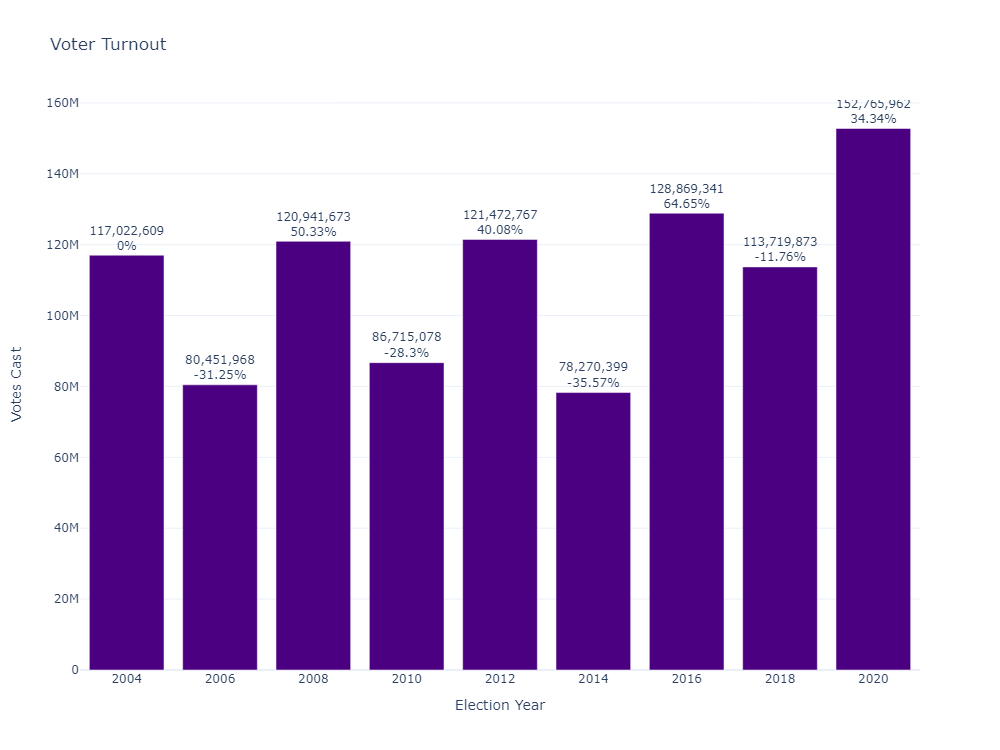

In [76]:
import plotly.express as px
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore") 

fig = px.bar(results.\
       groupby(['election_year']).agg(votes = ('total_votes','sum')).reset_index().\
              sort_values(['election_year'],ascending=[True])\
             .assign(chng = lambda x: (x.votes.pct_change()*100).round(2).astype(str).replace("nan","0")+"%"),
       template="plotly_white",title= 'Voter Turnout',x='election_year',y='votes',text='votes',custom_data=['chng']).\
update_traces(textposition='outside',texttemplate = "%{value:,}<br>%{customdata[0]}",marker_color = 'indigo').\
update_xaxes(title = "Election Year").\
update_yaxes(title = "Votes Cast")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Moving onto the winners, the viz below shows the results by year of each party outcome.

2010 was an particularly successful year for Republicans with the Tea Party flipping many seats help by Democrats. 2010 resulted in the highest losses by the president's party in a midterm election since 1938.

2018 was particularly successful for Democrats, flipping 42 seats, and regained control of the House. It was the largest mideterm turnout since the beginning of the 1900s.

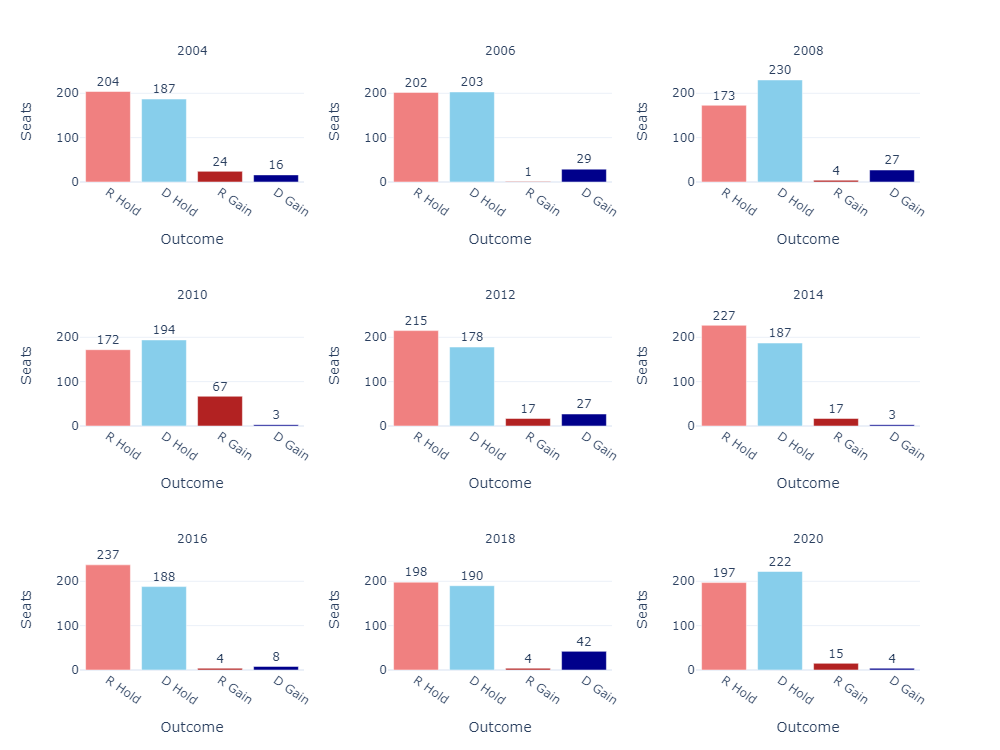

In [77]:
fig = px.bar(results.\
       groupby(['election_year','party_outcome']).agg(count = ('fec_id','count')).reset_index().\
       sort_values(['election_year','count'],ascending=[True,False]),
       color_discrete_map={"R Gain":"firebrick","R Hold":"lightcoral",
                           "D Gain":"darkblue","D Hold":"skyblue"},
       template="plotly_white",facet_col='election_year',y='count',x='party_outcome',color='party_outcome',facet_col_wrap=3,
      facet_col_spacing = .10,
      facet_row_spacing = .20,
       text='count',
      height=750).\
update_traces(textposition = 'outside').\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_xaxes(matches=None, showticklabels=True, visible=True,title="Outcome").\
update_yaxes(matches=None, showticklabels=True, visible=True,title='Seats',range=[0,275]).\
for_each_xaxis(lambda x: x.update(tickangle = 35)).\
update_layout(showlegend=False)

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)


The below maps visualize the extent of net gains in each state.

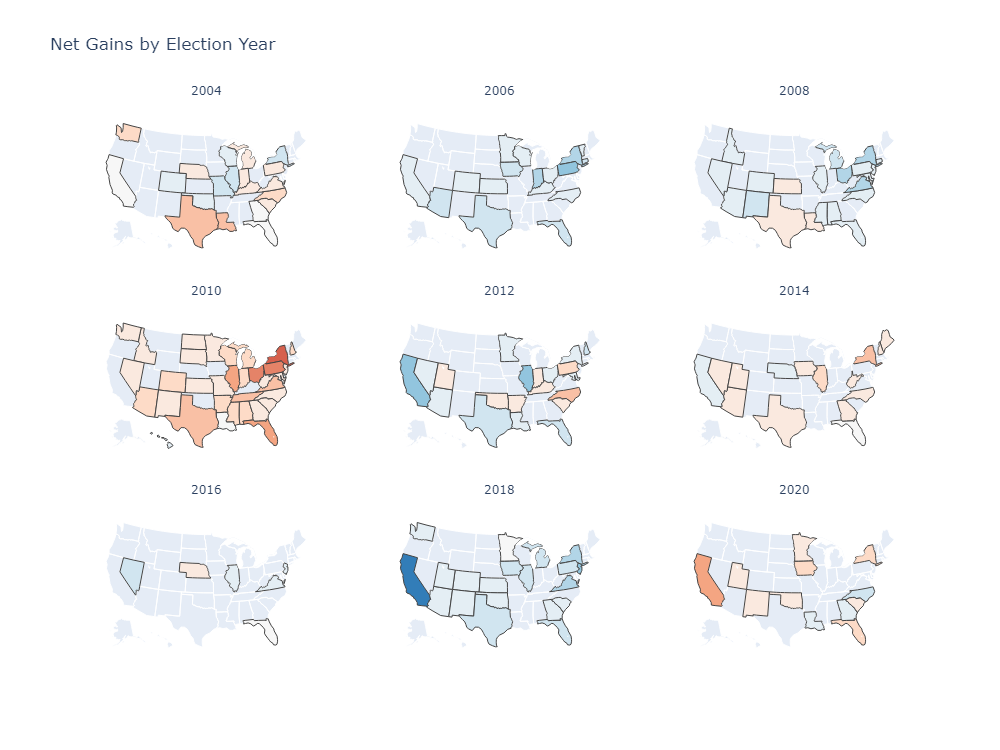

In [78]:
import plotly.express as px
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore") 

resultsmap = results.query("party_outcome in ('R Gain','D Gain')").\
       groupby(['election_year','state','winning_party']).agg(count = ('fec_id','count')).reset_index().\
pivot(index=['election_year','state'],columns='winning_party',values='count').\
reset_index().fillna(0).assign(factor = lambda x: x.R- x.D)

resultsmap['state_code'] = resultsmap.state.map({'District of Columbia': 'DC',

    # States
    'Alabama': 'AL',
    'Montana': 'MT',
    'Alaska': 'AK',
    'Nebraska': 'NE',
    'Arizona': 'AZ',
    'Nevada': 'NV',
    'Arkansas': 'AR',
    'New Hampshire': 'NH',
    'California': 'CA',
    'New Jersey': 'NJ',
    'Colorado': 'CO',
    'New Mexico': 'NM',
    'Connecticut': 'CT',
    'New York': 'NY',
    'Delaware': 'DE',
    'North Carolina': 'NC',
    'Florida': 'FL',
    'North Dakota': 'ND',
    'Georgia': 'GA',
    'Ohio': 'OH',
    'Hawaii': 'HI',
    'Oklahoma': 'OK',
    'Idaho': 'ID',
    'Oregon': 'OR',
    'Illinois': 'IL',
    'Pennsylvania': 'PA',
    'Indiana': 'IN',
    'Rhode Island': 'RI',
    'Iowa': 'IA',
    'South Carolina': 'SC',
    'Kansas': 'KS',
    'South Dakota': 'SD',
    'Kentucky': 'KY',
    'Tennessee': 'TN',
    'Louisiana': 'LA',
    'Texas': 'TX',
    'Maine': 'ME',
    'Utah': 'UT',
    'Maryland': 'MD',
    'Vermont': 'VT',
    'Massachusetts': 'MA',
    'Virginia': 'VA',
    'Michigan': 'MI',
    'Washington': 'WA',
    'Minnesota': 'MN',
    'West Virginia': 'WV',
    'Mississippi': 'MS',
    'Wisconsin': 'WI',
    'Missouri': 'MO',
    'Wyoming': 'WY',
})

fig = px.choropleth(resultsmap,
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='factor',
                    facet_col='election_year',
                    color_continuous_scale=px.colors.sequential.RdBu_r,
                    range_color=[-10,10],
                    facet_col_wrap=3,
                    height=1000,
                    facet_col_spacing = .05,
                    facet_row_spacing = .05,
                    title = 'Net Gains by Election Year'
                    )\
.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title()))\
.update_coloraxes(showscale=False)

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

The overall margin of victory distributions are visulaized below. The dispersion and median have been more or less consistent since 2004.

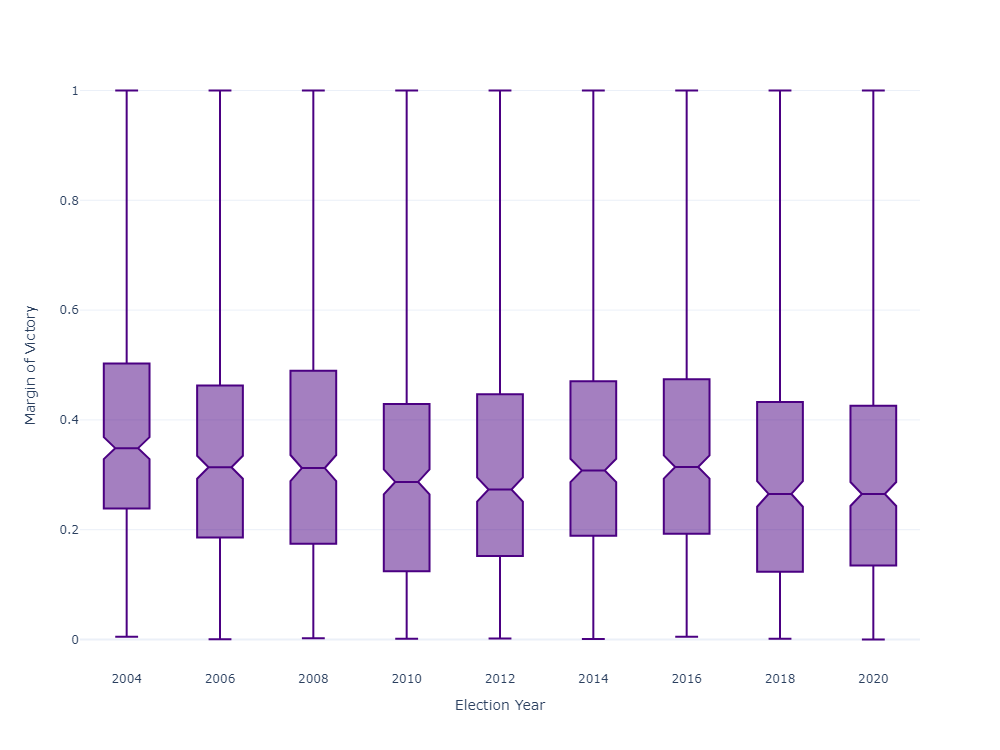

In [79]:
import plotly.express as px

fig =px.box(results.query("mov>0"),y="mov", x="election_year",width=1000,points=None,
            template="plotly_white",notched=True).\
update_traces(marker_color='indigo',boxpoints=False).\
update_xaxes(title="Election Year").\
update_yaxes(title='Margin of Victory')

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

This viz show the margin of victory compared to the previous margin of victory for each seat (each data point represents a district).

Data points along the diagonal would represent a similar year over year victory. Points in the upper left represent a district being more competative, while the bottom right would represent a stengthening partisan preferences.

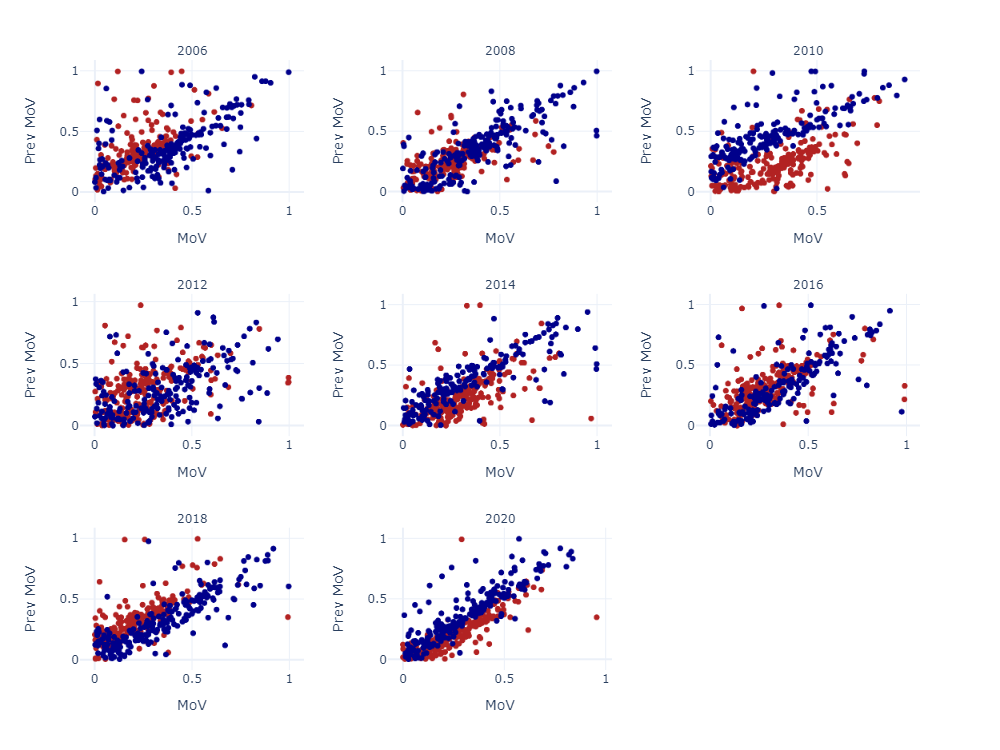

In [80]:
fig = px.scatter(results.query("mov < 1 & prev_mov < 1"),x="mov",y="prev_mov",color="winning_party",
           color_discrete_map={"R":"firebrick","D":"darkblue"},facet_col='election_year',facet_col_wrap=3,
          template="plotly_white",facet_col_spacing = .10,
      facet_row_spacing = .15)\
.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_layout(showlegend=False).\
update_xaxes(matches=None, showticklabels=True, visible=True,title="MoV").\
update_yaxes(matches=None, showticklabels=True, visible=True,title="Prev MoV")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

## Macro-Political Data

Here I add data around the composition of the government, including the president's party. I also add regional demographics for each State. 

In [82]:
congress = pd.read_csv("FEC Election Data/Congress.csv").clean_names()

region = pd.read_csv("FEC Election Data//USregions.csv").clean_names()
results = results.merge(region,left_on="state",right_on="state",how="inner")

In [83]:
congress

,election_influence_year,election_year,democrats_senate,republicans_senate,democrats_house,republicans_house,president,house,senate,unified,presidential_election_year
0,2002,2000,50,50,212,221,R,R,D,N,0
1,2004,2002,48,51,205,229,R,R,R,Y,1
2,2006,2004,44,55,202,232,R,R,R,Y,0
3,2008,2006,49,49,233,202,R,D,D,N,1
4,2010,2008,56,40,257,178,D,D,D,Y,0
5,2012,2010,51,47,193,242,D,R,D,N,1
6,2014,2012,53,45,201,234,D,R,D,N,0
7,2016,2014,44,54,188,247,D,R,R,N,1
8,2018,2016,46,50,194,241,R,R,R,Y,0
9,2020,2018,45,53,235,200,R,D,R,N,1


The two years represent the election year and the election influence year. My premise for this approach rests on the fact that the results of the previous elections will weigh on the results of the next cycle, and currect election data would never be available to model an upcoming election.

I add a few columns to the results data below.

In [84]:
results = results.merge(congress.drop(['election_year'],axis=1),left_on="election_year",right_on="election_influence_year",how="left")
results['house'] = np.where(results['incumbent_party'] == results['house'],'Incumbent Party House','Opposition Party House')
results['senate'] =  np.where(results['incumbent_party'] == results['senate'],'Incumbent Party Senate','Opposition Party Senate')
results['president'] = np.where(results['incumbent_party'] == results['president'],'Incumbent Party President','Opposition Party President')

In [85]:
results.sample(10)

,state,state_code_x,district,fec_id,incumbent_indicator,election_year,general,winning_party,candidate_name,district_type,...,election_influence_year,democrats_senate,republicans_senate,democrats_house,republicans_house,president,house,senate,unified,presidential_election_year
1485,Kentucky,KY,4,H2KY04071,Incumbent,2006,105845,R,"Davis, Geoff",House,...,2006,44,55,202,232,Incumbent Party President,Incumbent Party House,Incumbent Party Senate,Y,0
596,California,CA,43,H4CA23011,Incumbent,2018,152272,D,"Waters, Maxine",House,...,2018,46,50,194,241,Opposition Party President,Opposition Party House,Opposition Party Senate,Y,0
479,California,CA,32,H8CA34068,Incumbent,2014,50353,D,"Napolitano, Grace F.",House,...,2014,53,45,201,234,Incumbent Party President,Opposition Party House,Incumbent Party Senate,N,0
710,Colorado,CO,2,H8CO02160,Open Seat,2018,259608,D,"Neguse, Joe",House,...,2018,46,50,194,241,Opposition Party President,Opposition Party House,Opposition Party Senate,Y,0
3721,Washington,WA,9,H6WA09025,Incumbent,2012,192034,D,"Smith, Adam",House,...,2012,51,47,193,242,Incumbent Party President,Opposition Party House,Incumbent Party Senate,N,1
1986,Mississippi,MS,3,H8MS03067,Incumbent,2016,209490,R,"Harper, Gregg",House,...,2016,44,54,188,247,Opposition Party President,Incumbent Party House,Incumbent Party Senate,N,1
3202,Tennessee,TN,1,H6TN01388,Incumbent,2014,115533,R,"Roe, Phil",House,...,2014,53,45,201,234,Opposition Party President,Incumbent Party House,Opposition Party Senate,N,0
3620,Virginia,VA,10,H6VA10050,Incumbent,2010,131116,R,"Wolf, Frank R.",House,...,2010,56,40,257,178,Opposition Party President,Opposition Party House,Opposition Party Senate,Y,0
735,Connecticut,CT,3,H0CT03072,Incumbent,2008,230172,D,"DeLauro, Rosa L.",House,...,2008,49,49,233,202,Opposition Party President,Incumbent Party House,Incumbent Party Senate,N,1
2740,Ohio,OH,3,H2OH03125,Open Seat,2012,201921,D,"Beatty, Joyce",House,...,2012,51,47,193,242,Opposition Party President,Incumbent Party House,Opposition Party Senate,N,1


In [86]:
results.shape

(3879, 33)

In [87]:
results.columns

Index(['state', 'state_code_x', 'district', 'fec_id', 'incumbent_indicator',
       'election_year', 'general', 'winning_party', 'candidate_name',
       'district_type', 'general_pct', 'mov', 'total_votes', 'rank', 'outcome',
       'incumbent_party', 'open_seat', 'party_outcome', 'prev_mov',
       'prev_candidate_wins', 'state_code_y', 'region', 'division',
       'election_influence_year', 'democrats_senate', 'republicans_senate',
       'democrats_house', 'republicans_house', 'president', 'house', 'senate',
       'unified', 'presidential_election_year'],
      dtype='object')

In [88]:
results.groupby(['election_year']).fec_id.count()

election_year
2004    428
2006    431
2008    430
2010    433
2012    426
2014    431
2016    434
2018    431
2020    435
Name: fec_id, dtype: int64

### Census Data

In [89]:
censusFiles = [f for f in listdir(r"FEC Election Data/Census") 
if isfile(join(r"FEC Election Data/Census", f))]

censusFiles

acs = pd.DataFrame()

for file in censusFiles:
  varDF = pd.read_csv("FEC Election Data/Census/"+file)
  varDF['File'] = file
  varDF = varDF.melt(id_vars = ['File','Label (Grouping)'])
  acs =   pd.concat([acs,varDF]).dropna()

del varDF
acs = acs.clean_names(strip_underscores=True, case_type='lower', remove_special=True)
acs.sample(10)


,file,label_grouping,variable,value
52103,ACSST5Y2020.S0101-2023-03-27T202306.csv,Under 18 years,"Congressional District 15 (116th Congress), Fl...","92,090"
129871,ACSST5Y2020.S0101-2023-03-27T202306.csv,25 to 29 years,"Congressional District 12 (116th Congress), Ne...","22,355"
160930,ACSST5Y2020.S0101-2023-03-27T202306.csv,21 years and over,"Congressional District 2 (116th Congress), Okl...",±0.1
51109,ACSST1Y2012.S0101-2023-03-27T224353.csv,65 years and over,"Congressional District 2 (113th Congress), Wes...",17.6%
4965,ACSST1Y2012.S1701-2023-03-28T011643.csv,Did not work,"Congressional District 10 (113th Congress), Ca...","17,491"
3324,ACSST1Y2010.S0101-2023-03-27T202207.csv,10 to 14 years,"Congressional District 8 (111th Congress), Cal...",3.1%
71327,ACSST5Y2020.S0101-2023-03-27T202306.csv,45 to 49 years,"Congressional District 8 (116th Congress), Ill...",6.6%
41790,ACSST1Y2010.S0101-2023-03-27T202207.csv,75 years and over,"Congressional District 18 (111th Congress), Pe...",9.3%
29735,DECENNIALDPCD110H2000.DP1-2023-03-27T203045.csv,"For seasonal, recreational, or occ...","Congressional District 24 (110th Congress), Ne...",4.5
11137,ACSST1Y2010.S0101-2023-03-27T202207.csv,75 to 79 years,"Congressional District 6 (111th Congress), Flo...",3.2%


In [90]:
acs['census_year'] = acs['file'].str.extract("(\\d{4}\\.)").fillna(1000).replace("\\.",'',regex=True)
acs['district'] = acs.variable.str.split(',').str[0].str.extract("(\\d+)").fillna(0).astype(int)
acs['district'] = np.where(acs['district'] > 100,'0',acs['district']).astype(object)
acs['state'] = acs.variable.str.split(',').str[1].str.extract("([A-Za-z\\s]+)")
acs['qualifier'] = acs.variable.str.extract("(Male|Female)").fillna('Total')

In [91]:
#acs = acs.drop(['file','variable'],axis=1)
acs['label_grouping'] = acs['label_grouping'].str.strip()
acs = acs.transform(lambda x: x.str.strip())
acs = acs[~acs["value"].str.contains("±",na=False)].replace(r"(X)",np.nan).dropna()
acs =acs[~acs["variable"].str.contains("not defined",na=False)]
acs =acs[acs["value"].str.contains(r"[0-9]",na=False)]
acs['value'] = acs.value.str.replace(r",|%","",regex=True).astype(float)

In [92]:
acs.sample(10)

,file,label_grouping,variable,value,census_year,district,state,qualifier
14381,ACSST5Y2020.S0101-2023-03-27T202306.csv,75 to 79 years,"Congressional District 8 (116th Congress), Cal...",2.2,2020,8,California,Male
95431,ACSST5Y2020.S0101-2023-03-27T202306.csv,25 to 29 years,"Congressional District 6 (116th Congress), Mar...",25565.0,2020,6,Maryland,Male
18320,DECENNIALDPSF32000.DP3-2023-03-28T005907.csv,Manufacturing,"Congressional District 4 (106th Congress), Con...",11.5,2000,4,Connecticut,Total
30934,ACSST1Y2012.S1701-2023-03-28T011643.csv,Male,"Congressional District 1 (113th Congress), Mas...",24.3,2012,1,Massachusetts,Total
15772,ACSST1Y2010.S0101-2023-03-27T202207.csv,50 to 54 years,"Congressional District 3 (111th Congress), Ill...",7.5,2010,3,Illinois,Male
13823,DECENNIALDPCD110H2000.DP1-2023-03-27T203045.csv,"For seasonal, recreational, or occasional use","Congressional District 24 (110th Congress), Te...",962.0,2000,24,Texas,Total
39936,ACSST1Y2010.S0101-2023-03-27T202207.csv,70 to 74 years,"Congressional District 2 (111th Congress), Pen...",3.0,2010,2,Pennsylvania,Female
39349,ACSST1Y2012.S0101-2023-03-27T224353.csv,65 years and over,"Congressional District 3 (113th Congress), Pen...",19.1,2012,3,Pennsylvania,Female
38849,ACSST1Y2012.S1701-2023-03-28T011643.csv,High school graduate (includes equivalency),"Congressional District 3 (113th Congress), Nev...",8.8,2012,3,Nevada,Total
90679,DECENNIALDPCD110H2000.DP1-2023-03-27T203045.csv,"For seasonal, recreational, or occasional use","Congressional District 25 (110th Congress), Te...",1.7,2000,25,Texas,Total


In [93]:
acs.census_year.unique()

array(['2010', '2012', '2020', '2000'], dtype=object)

In [94]:
employed = acs.query("label_grouping == 'Employed'").\
sort_values(['census_year','district','state','value'],ascending=[True,True,True,False]).\
drop_duplicates(subset=['census_year','district','state'],keep='first')\
[['value','census_year','district','state']].rename(columns={"value":"employed"})
employed

,employed,census_year,district,state
1614,281532.0,2000,0,Alaska
18864,376811.0,2000,0,Delaware
19094,263108.0,2000,0,District of Columbia
53364,425977.0,2000,0,Montana
68774,316632.0,2000,0,North Dakota
...,...,...,...,...
53974,305699.0,2012,9,Pennsylvania
58510,309207.0,2012,9,Tennessee
59968,337028.0,2012,9,Texas
66610,295066.0,2012,9,Virginia


In [95]:
median_age = acs[acs['label_grouping'] == 'Median age (years)'].\
pivot(index=['census_year' ,'district' ,'state'], columns='qualifier',values = 'value').reset_index()
median_age

qualifier,census_year,district,state,Female,Male,Total
0,2000,0,Alaska,NaN,NaN,32.4
1,2000,0,Delaware,NaN,NaN,36.0
2,2000,0,District of Columbia,NaN,NaN,34.6
3,2000,0,Montana,NaN,NaN,37.5
4,2000,0,North Dakota,NaN,NaN,36.2
...,...,...,...,...,...,...
1743,2020,9,Pennsylvania,45.2,41.8,43.4
1744,2020,9,Tennessee,35.6,32.1,33.8
1745,2020,9,Texas,33.9,32.6,33.2
1746,2020,9,Virginia,45.4,41.5,43.5


In [96]:
mf_2010 = acs[acs['label_grouping'] == 'Total population'].query("census_year > '2000'").\
pivot(index=['census_year' ,'district' ,'state'], columns='qualifier',values = 'value').reset_index()

mf_2000 = pd.merge(acs[acs['label_grouping'] == 'Male'].query("census_year == '2000'")\
.sort_values(['census_year','district','state','value'],ascending=[True,True,True,False])\
.drop_duplicates(subset=['census_year','district','state'],keep='first').\
pivot(index=['census_year' ,'district' ,'state'], columns='qualifier',values = 'value').reset_index(),

acs[acs['label_grouping'] == 'Female'].query("census_year == '2000'")\
.sort_values(['census_year','district','state','value'],ascending=[True,True,True,False])\
.drop_duplicates(subset=['census_year','district','state'],keep='first').\
pivot(index=['census_year' ,'district' ,'state'], columns='qualifier',values = 'value').reset_index(),
        on=['census_year','district','state'],suffixes=("_male","_female")).assign(Total = lambda x: x.Total_female+x.Total_male).\
rename(columns={"Total_male":"Male","Total_female":"Female"})

mf = pd.concat([mf_2010,mf_2000])

In [97]:
acs = pd.merge(mf,median_age,on=['census_year','district','state'],suffixes=("_population","_median_age"))\
.merge(employed,on=['census_year','district','state'])\
.clean_names()\
.dropna(axis=1)\
.assign(mf_ratio = lambda x: x.female_population/x.male_population,
       census_year = lambda x: x.census_year.astype(int),
       employed = lambda x: (x.employed/x.total_population)
       )[['census_year','district','state','mf_ratio','total_median_age','employed']]

acs.sample(10)

,census_year,district,state,mf_ratio,total_median_age,employed
473,2000,1,New Mexico,1.041524,35.1,0.455084
851,2000,9,Michigan,1.043081,37.5,0.451097
98,2012,14,California,1.028438,39.8,0.508625
49,2012,1,Washington,0.991089,38.2,0.486337
515,2000,12,Florida,1.038045,37.4,0.446421
594,2000,2,Massachusetts,1.093170,36.6,0.468888
450,2000,1,Colorado,0.981353,33.2,0.536947
852,2000,9,Missouri,1.031255,35.4,0.553211
516,2000,12,Illinois,1.053279,36.0,0.376257
559,2000,17,New York,1.141525,34.9,0.355966


In [98]:
acs.to_csv("acs.csv")

### Model Data

In [99]:
results['census_year'] = results.election_year\
.map({2004:2000,2006:2000,2008:2000,2010:2000,2012:2012,2014:2012,2016:2012,2018:2012,2020:2012,2022:2020}).astype(int)

In [100]:
resultsModelData = results.query("outcome == 'W' & district_type == 'House' & winning_party != 'O'")\
[['candidate_name','state','district','region','division','election_year','census_year',
  'incumbent_indicator','incumbent_party','prev_candidate_wins','presidential_election_year','unified',
  'president','house','prev_mov','mov','party_outcome','winning_party']].assign(district = lambda x: x.district.astype(str))

In [102]:
resultsModelData.groupby(['election_year']).winning_party.count()

election_year
2004    428
2006    431
2008    430
2010    433
2012    426
2014    431
2016    434
2018    431
2020    435
Name: winning_party, dtype: int64

## Model

In [103]:
resultsModelData = resultsModelData.merge(acs,left_on=['census_year','state','district'],
                                          right_on=['census_year','state','district'],how='left').\
set_index('candidate_name').dropna(subset=['region'])
resultsModelData.index.name = None

In [104]:
resultsModelData.shape

(3879, 20)

In [105]:
resultsModelData.sample(10)

,state,district,region,division,election_year,census_year,incumbent_indicator,incumbent_party,prev_candidate_wins,presidential_election_year,unified,president,house,prev_mov,mov,party_outcome,winning_party,mf_ratio,total_median_age,employed
"Gottheimer, Josh",New Jersey,5,Northeast,Middle Atlantic,2018,2012,Incumbent,D,1,0,Y,Opposition Party President,Opposition Party House,0.044113,0.136805,D Hold,D,1.063352,42.8,0.499563
"Riggleman, Denver L., III #",Virginia,5,South,South Atlantic,2018,2012,Open Seat,R,0,0,Y,Incumbent Party President,Incumbent Party House,0.166862,0.065401,R Hold,R,1.069957,41.7,0.431667
"Kennedy, Patrick J.",Rhode Island,1,Northeast,New England,2004,2000,Incumbent,D,0,1,Y,Opposition Party President,Opposition Party House,1.000000,0.282950,D Hold,D,1.095480,36.8,0.467749
"Bonner, Jo",Alabama,1,South,Deep South,2008,2000,Incumbent,R,2,1,N,Incumbent Party President,Opposition Party House,0.363120,1.000000,R Hold,R,1.071946,35.7,0.421313
"Cotton, Tom",Arkansas,4,South,Deep South,2012,2012,Open Seat,D,0,1,N,Incumbent Party President,Opposition Party House,0.173762,0.228366,R Gain,R,1.040565,40.5,0.403014
"Langevin, James R.",Rhode Island,2,Northeast,New England,2012,2012,Incumbent,D,4,1,N,Incumbent Party President,Opposition Party House,0.281049,0.206223,D Hold,D,1.083836,41.1,0.496033
"Sessions, Pete",Texas,32,South,Deep South,2008,2000,Incumbent,R,2,1,N,Incumbent Party President,Opposition Party House,0.151533,0.166791,R Hold,R,NaN,NaN,NaN
"Payne, Donald M., Jr.",New Jersey,10,Northeast,Middle Atlantic,2020,2012,Incumbent,D,3,1,N,Opposition Party President,Incumbent Party House,0.774694,0.693854,D Hold,D,1.088413,36.3,0.425650
"Lujan Grisham, Michelle",New Mexico,1,West,Mountain,2016,2012,Incumbent,D,2,1,N,Incumbent Party President,Opposition Party House,0.171725,0.302946,D Hold,D,1.030610,37.2,0.451314
"Moran, James P., Jr.",Virginia,8,South,South Atlantic,2006,2000,Incumbent,D,1,0,Y,Opposition Party President,Opposition Party House,0.228935,0.359012,D Hold,D,1.022310,34.7,0.545357


In [106]:
resultsModelData.groupby(['election_year']).winning_party.count()

election_year
2004    428
2006    431
2008    430
2010    433
2012    426
2014    431
2016    434
2018    431
2020    435
Name: winning_party, dtype: int64

In [107]:
resultsModelData[resultsModelData.isnull().any(axis=1)].shape[0]/resultsModelData.shape[0]

0.02088167053364269

In [108]:
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA,KernelPCA
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,StratifiedKFold,cross_val_score,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder,FunctionTransformer,KBinsDiscretizer,StandardScaler,OneHotEncoder,OrdinalEncoder,PowerTransformer,MinMaxScaler
from sklearn.metrics import *
import scipy.stats as stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [119]:
target_name = 'party_outcome'

def electionWin(meta):
    clf = tf.keras.Sequential()
    clf.add(tf.keras.layers.Input(shape=(meta["n_features_in_"])))
    clf.add(Dense(50, activation='tanh',kernel_initializer=tf.keras.initializers.Identity()))
    clf.add(Dense(100, activation='relu'))
    clf.add(Dropout(.35))
    clf.add(Dense(140, activation='tanh',kernel_initializer=tf.keras.initializers.Identity()))
    clf.add(Dense(4, activation='softmax'))
    clf.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,use_ema=True,ema_momentum=.90))
    return clf
clf = KerasClassifier(electionWin, 
                      epochs=100,
                      batch_size = 10,
                      verbose=1,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.005,use_ema=True)
                     )

pipe = make_pipeline(ColumnTransformer(
  transformers = [
  ('OHE',OneHotEncoder(handle_unknown='infrequent_if_exist'),
   ['incumbent_indicator','state','president','region','division','unified','incumbent_party','house']),
  ('KBin',KBinsDiscretizer(encode='ordinal',strategy='uniform',n_bins=6),['prev_mov']),
  ('Scale',StandardScaler(),['total_median_age'])
  ],
  remainder = 'passthrough'), 
  clf)

In [120]:
#train,test = train_test_split(resultsModelData,test_size=435)

train = resultsModelData.query("election_year < 2020").dropna()
test = resultsModelData.query("election_year == 2020").dropna()


X = train.drop([target_name,'mov','winning_party','election_year','census_year'],axis = 1)
Y = train[[target_name]].values.ravel()

In [121]:
Y

array(['R Hold', 'R Hold', 'R Hold', ..., 'D Hold', 'D Hold', 'D Hold'],
      dtype=object)

In [122]:
resultsModelData.election_year.unique()

array([2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020], dtype=int64)

In [123]:
pipe.fit(X,Y)

Epoch 1/100
337/337 [==============================] - 4s 4ms/step - loss: 0.2364
Epoch 2/100
337/337 [==============================] - 2s 4ms/step - loss: 0.0712
Epoch 3/100
337/337 [==============================] - 1s 4ms/step - loss: 0.0606
Epoch 4/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0562
Epoch 5/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0566
Epoch 6/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0453
Epoch 7/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0465
Epoch 8/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0507
Epoch 9/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0451
Epoch 10/100
337/337 [==============================] - 1s 4ms/step - loss: 0.0408
Epoch 11/100
337/337 [==============================] - 1s 4ms/step - loss: 0.0384
Epoch 12/100
337/337 [==============================] - 2s 5ms/step - loss: 0.0361
Epoch 13/100


337/337 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 100/100
337/337 [==============================] - 2s 4ms/step - loss: 0.0208


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['incumbent_indicator',
                                                   'state', 'president',
                                                   'region', 'division',
                                                   'unified', 'incumbent_party',
                                                   'house']),
                                                 ('KBin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=6,
                                                                   strategy='uniform'),
                                                  ['prev_mov']),
                                                 ('Scale', StandardScaler(),
                                                  ['total_median_age'])])),
                ('kerasclassifier',
                 KerasClassifier(batch_size=10, epochs=100, model=<function electionWin at 0x00000260F898AE50>, optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x00000260F0DCB430>))])

In [124]:
pd.options.mode.chained_assignment = None
test[target_name+'_predicted'] = pipe.predict(test.drop([target_name,'mov','winning_party','election_year','census_year'],axis = 1))


44/44 [==============================] - 0s 3ms/step


### Predictions

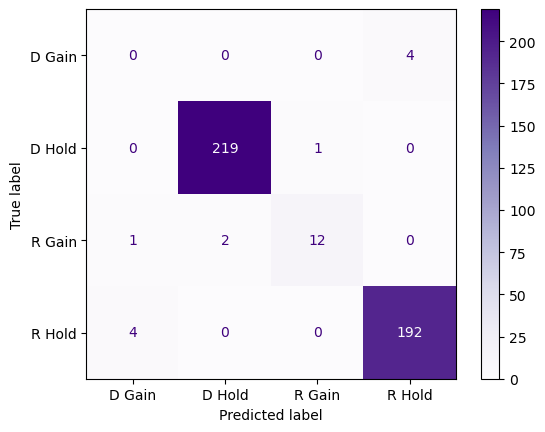

In [125]:
#perfomance
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(confusion_matrix(test[target_name], test[target_name+'_predicted']),
                       display_labels=pipe.classes_).\
plot(cmap=plt.cm.Purples)

In [126]:
pd.DataFrame(classification_report(test[target_name], test[target_name+'_predicted'],output_dict=True)).T

,precision,recall,f1-score,support
D Gain,0.000000,0.000000,0.000000,4.000000
D Hold,0.990950,0.995455,0.993197,220.000000
R Gain,0.923077,0.800000,0.857143,15.000000
R Hold,0.979592,0.979592,0.979592,196.000000
accuracy,0.972414,0.972414,0.972414,0.972414
macro avg,0.723405,0.693762,0.707483,435.000000
weighted avg,0.974380,0.972414,0.973243,435.000000


In [127]:
test.party_outcome.value_counts().reset_index()\
.merge(test.party_outcome_predicted.value_counts().reset_index())

,index,party_outcome,party_outcome_predicted
0,D Hold,220,221
1,R Hold,196,196
2,R Gain,15,13
3,D Gain,4,5


In [128]:
test.query("party_outcome_predicted != party_outcome")

,state,district,region,division,election_year,census_year,incumbent_indicator,incumbent_party,prev_candidate_wins,presidential_election_year,...,president,house,prev_mov,mov,party_outcome,winning_party,mf_ratio,total_median_age,employed,party_outcome_predicted
"Carl, Jerry",Alabama,1,South,Deep South,2020,2012,Open Seat,R,0,1,...,Incumbent Party President,Opposition Party House,0.263976,0.288575,R Hold,R,1.060911,38.7,0.402615,D Gain
"Moore, Barry",Alabama,2,South,Deep South,2020,2012,Open Seat,R,0,1,...,Incumbent Party President,Opposition Party House,0.230052,0.305689,R Hold,R,1.064459,37.8,0.408554,D Gain
"Valadao, David G.",California,21,West,Pacific,2020,2012,Challenger,D,2,1,...,Opposition Party President,Incumbent Party House,0.007587,0.008935,R Gain,R,0.877772,28.5,0.339790,D Hold
"Garcia, Mike",California,25,West,Pacific,2020,2012,Open Seat,D,0,1,...,Opposition Party President,Incumbent Party House,0.087323,0.000982,R Gain,R,0.983662,34.7,0.427845,D Hold
"Steel, Michelle",California,48,West,Pacific,2020,2012,Challenger,D,0,1,...,Opposition Party President,Incumbent Party House,0.071040,0.021200,R Gain,R,1.017973,40.3,0.499567,D Gain
"Franklin, Scott",Florida,15,South,South Atlantic,2020,2012,Open Seat,R,0,1,...,Incumbent Party President,Opposition Party House,0.060407,0.107704,R Hold,R,1.078868,37.8,0.440078,D Gain
"Bourdeaux, Carolyn",Georgia,7,South,Deep South,2020,2012,Open Seat,R,0,1,...,Incumbent Party President,Opposition Party House,0.001494,0.027825,D Gain,D,1.009606,35.2,0.472549,R Hold
"Mrvan, Frank J.",Indiana,1,Midwest,Rust Belt,2020,2012,Open Seat,D,0,1,...,Opposition Party President,Incumbent Party House,0.301858,0.161900,D Hold,D,1.046280,38.1,0.425757,R Gain
"Christophe, Sandra ""Candy""",Louisiana,5,South,Deep South,2020,2012,Open Seat,R,0,1,...,Incumbent Party President,Opposition Party House,0.365713,0.006929,D Gain,D,1.027940,36.5,0.374923,R Hold
"Ross, Deborah K.",North Carolina,2,South,South Atlantic,2020,2012,Open Seat,R,0,1,...,Incumbent Party President,Opposition Party House,0.054552,0.281305,D Gain,D,1.046224,35.9,0.413823,R Hold
